# Stock linear regression analysis
Build the linear regression models of stocks to get the coefficients representing trends (class method)

# Part 1:  build functions and test using stock_list_test.txt

In [1]:
import numpy as np
from sklearn import datasets, linear_model
import pandas as pd
import matplotlib.pyplot as pl

For the consistency of the whole project, read the stock list of all the symbols we needed in the text file.
- The stock_list_test.txt is cutted from the stock_list.txt, and it should be in the same directory as this ipynb file.
- The stock_list.txt is generated from the first part of the project

In [2]:
# function1 to get stock list from text file
def get_list(filename):
    # pandas read file into data frame
    stocks = pd.read_csv(filename, header = None)
    stocks[0] = stocks[0].str.upper()
    # convert the data frame to numpy array
    stock_array = stocks.values
    return stock_array

In [3]:
# function1 using example using stock_list_test.txt
stock_array = get_list('stock_list_test.txt')
stock_array[:5]

array([['A'],
       ['AA'],
       ['AABA'],
       ['AAL'],
       ['AAOI']], dtype=object)

For fetching historical data from yahoo finance, an addtional package pandas_datareader are used here, which can be installed with pip from the command line:

pip install pandas-datareader

We can specify the stock symbol, start date, end date and also the data source.

There are three exceptions defined for handling error while fetching data using datareader:
- error RemoteDataError: when the symbol is not valid and can't be find in the dataset
- error KeyError: when there isn't full data for the input data range(start, end)

In [4]:
import pandas_datareader.data as web
import datetime
from pandas_datareader._utils import RemoteDataError

# Considering data from 2018 to 2019 for latest trend
start = datetime.datetime(2018, 4, 1)
end = datetime.datetime(2019, 4, 1)

# function2: get historical data for a specific stock, using symbol as the parameter
def load_stock_data(symbol):
    try:
        df = web.DataReader(symbol, 'yahoo', start, end)
    except RemoteDataError:
        print("No search result : '" + symbol + "'")
        return float('NaN')
    except KeyError:
        print("Date range not supported : '" + symbol + "'")
        return float('NaN')
    close = df[['Close']]
    
    # Normalize close value by divided by the base value (the close price of the earliest day) and multiplied by 100
    base = close.iloc[0]['Close']
    # neglect the stocks the initial close price < 25 USD to insure the selected stock value
    if base > 10 :
        close = close.assign(Close = close['Close'] / base * 100)
    return close

In [5]:
A_close = load_stock_data('A')
A_close[:5]

,Close
Date,
2018-04-02,100.000000
2018-04-03,101.536548
2018-04-04,101.583108
2018-04-05,101.940090
2018-04-06,98.789386


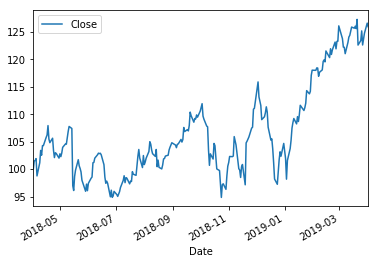

In [6]:
# function2 using example
A_close = load_stock_data('A')
A_close.plot()
pl.show()

In [7]:
from sklearn.model_selection import train_test_split

# function2: build linear regression model for a specific stock
# parameter 
    # show_statistics: indicate if the statistics are printed 
    # show_dots: indicate if dots data needed
    # show_plot: indacate if the plot is shown
    
def build_linear_regression(symbol, show_statistics = True, show_dots = True, show_plot = True):
    close = load_stock_data(symbol)
    # if the close is not dataframe, return NaN
    if not isinstance(close, pd.DataFrame) :
        return float('NaN')
    
    # normalize datatime datatype to integer
    # simply converting datetime's to # of days since 2010-01-01 divided by 100
    close.index = (close.index - pd.to_datetime('2010-01-01')).days / 100
    close = close.reset_index()
    train, test= train_test_split(close)
    
    train_x = train.drop('Close', axis = 1)
    train_y = train[['Close']]
    test_x = test.drop('Close', axis = 1)
    test_y = test[['Close']]
    
    #call linear regression model
    regr = linear_model.LinearRegression()
    regr.fit(train_x,train_y)
    
    if show_statistics :
        # The coefficients
        print('Coefficients:', regr.coef_[0])
        # The mean squared error
        print("Mean squared error: %.2f"
        % np.mean((regr.predict(test_x) - test_y) ** 2))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % regr.score(test_x, test_y))
        print('features:', 'Date', 'Close_Price')
    
    if show_plot :
        pl.plot(test_x, regr.predict(test_x), label = symbol)
        pl.legend()
        
        # Plot outputs
        pl.xlabel('Date')
        pl.ylabel('Close Price')
        pl.title('Overall Linear Regression Model')

        if show_dots :
            pl.title(symbol + ' Linear Regression Model')
            pl.plot(test['Date'], test['Close'], linestyle='none', marker='o')
    
        pl.xticks(())
        pl.yticks(())
    # return the coefficient representing trend
    return regr.coef_[0][0]

Coefficients: [5.58574012]
Mean squared error: 34.40
Variance score: 0.58
features: Date Close_Price


5.585740117736639

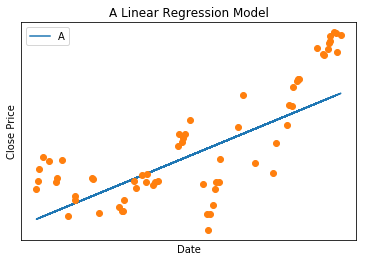

In [8]:
# function2 using example
build_linear_regression('A')

In [9]:
# function3: for each symbol in the text file, caculate the coefficents and record in the original text file
def get_coefficient_dataset(filename, show_statistics = False, show_dots = False, show_plot = True) :
    # load stock list data from text file
    stock_array = get_list(filename)
    # extend the 2D array from N * 1 to N * 2 to make place for putting corresponding coefficient
    stock_array = np.insert(stock_array, 1, values=0, axis=1) 
    
    # caculate coefficient for each symbol and store in the stock_array
    for symbol in stock_array:
        coefficient = build_linear_regression(symbol[0], show_statistics, show_dots, show_plot)
        symbol[1] = coefficient
    
    # transfer stock_array to dataframe with two columns 'Stock' and 'Coefficient'
    coefficient_data = pd.DataFrame(stock_array)
    coefficient_data.columns = ['Stock', 'Coefficient']
    
    # store the dataframe to csv file for future using
    coefficient_data.to_csv('Stock_Coefficients.csv')
    return coefficient_data

No search result : 'ANZ'


,Stock,Coefficient
0,A,5.62255
1,AA,-17.8993
2,AABA,-3.20013
3,AAL,-7.50604
4,AAOI,-35.1824


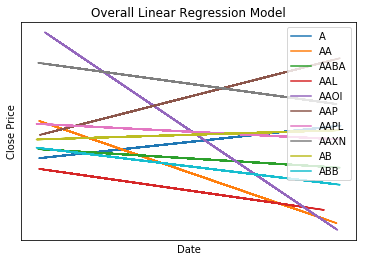

In [10]:
# function3 using example using stock_list_test.txt
coefficient_data_test = get_coefficient_dataset('stock_list_test.txt')
coefficient_data_test.head()

In [11]:
# function4 to get top n stocks with biggest coefficients
def get_top_stock(coefficient_data, n = 2) :
    # sort stocks by coefficients with descending order
    top_stocks = coefficient_data.sort_values(by = ['Coefficient'], ascending = False)
    # take top n stocks
    top_stocks = top_stocks[:n]
    top_stocks_list = top_stocks['Stock'].tolist()
    # plot stocks
    for symbol in top_stocks_list:
        build_linear_regression(symbol, show_statistics = False, show_dots = False, show_plot = True)
    # print stock list    
    print("The " + str(n) +" stocks with best trends are: ")
    print(top_stocks['Stock'].tolist())
    return top_stocks

The 2 stocks with best trends are: 
['AAP', 'A']


,Stock,Coefficient
6,AAP,13.3128
0,A,5.62255


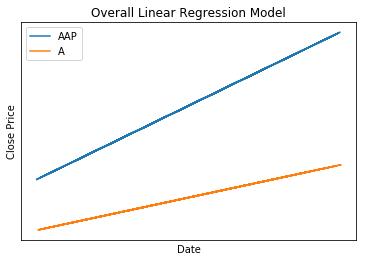

In [12]:
# function4 using example with coefficient_data_test
get_top_stock(coefficient_data_test)

In [13]:
# Function5 to get stocks with same trends
def get_similar_stock(coefficient_data, symbol, n = 3, show_dots = False):
    # sort stocks by coefficients with descending order
    top_stocks = coefficient_data.sort_values(by = ['Coefficient'], ascending = False)
    # get the specific row of the stcok symbol
    row = top_stocks.loc[top_stocks['Stock'] == symbol].iloc[-1]
    # get the offset in the column of that row in the sorted table
    offset = top_stocks.index.get_loc(row.name)
    
    # take similar stocks in the table from offset-3 to offset+3
    similar_stocks = top_stocks[offset-n : offset+n]
    similar_stocks_list = similar_stocks['Stock'].tolist()
    # plot stocks
    for symbol in similar_stocks_list:
        build_linear_regression(symbol, show_statistics = False, show_dots = show_dots, show_plot = True)
        
    # remove the row for the input symbol
    similar_stocks_delete = similar_stocks.drop(row.name)
    number = n*2 - 1
    print("The " + str(number) + " simialr stocks are: ")
    print(similar_stocks_delete['Stock'].tolist())
    return similar_stocks

The 1 simialr stocks are: 
['A']


,Stock,Coefficient
0,A,5.62255
9,AB,1.59592


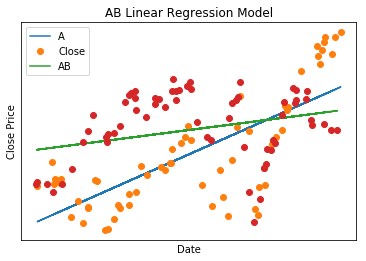

In [14]:
# function5 using example with coefficient_data_test, using symbol 'AAOI'
get_similar_stock(coefficient_data_test, 'AB', n = 1, show_dots = True)

# Part 2:  Get project result from stock_list.txt
The stock_list.txt is generated from the first part of the project, and it should be in the same directory as this ipynb file.

- The input is stock_list.txt
- The output is Stock_Coefficients.csv

# Setting: date range for fetching stock historial data
Input: stock_list.txt

In [15]:
# Considering data from 2018 to 2019 for consistency
start = datetime.datetime(2018, 4, 1)
end = datetime.datetime(2019, 4, 1)

# Result 1: Coefficient dataset and export file
Output: Stock_Coefficients.csv

In [16]:
# load full stock_list getting from part1 of this project(association rule)
# error will be printed with invaild symbol name or date keys
# generate output as file Stock_Coefficients.csv
coefficient_data = get_coefficient_dataset('stock_list.txt', show_plot = False)
coefficient_data.head()

No search result : 'ANZ'
Date range not supported : 'ELNK'
Date range not supported : 'ESRX'
No search result : 'ETP'
Date range not supported : 'GIMO'
Date range not supported : 'HAR'
Date range not supported : 'LNKD'
Date range not supported : 'MFS'
Date range not supported : 'MGT'
Date range not supported : 'MON'
Date range not supported : 'PCLN'
Date range not supported : 'RAI'
Date range not supported : 'SODA'
No search result : 'SSNLF'
No search result : 'TSMC'
Date range not supported : 'TWX'
Date range not supported : 'UWTI'
Date range not supported : 'VNR'
Date range not supported : 'VNTV'
Date range not supported : 'VRX'
Date range not supported : 'WFM'
No search result : 'WPZ'
No search result : 'ZNWAA'


,Stock,Coefficient
0,A,5.68586
1,AA,-18.3525
2,AABA,-3.55609
3,AAL,-7.98295
4,AAOI,-32.8479


# Result 2: Top five stocks

The 5 stocks with best trends are: 
['DOW', 'RETA', 'TTD', 'TWLO', 'IIPR']


,Stock,Coefficient
418,DOW,135.916
1133,RETA,81.879
1347,TTD,69.2973
1354,TWLO,61.6381
702,IIPR,42.8097


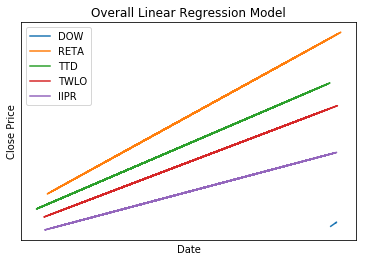

In [17]:
# Get top five stocks from the stock list
get_top_stock(coefficient_data, n = 5)

# Result 3: Similar five stocks for input symbol 'AMZN'

The 5 simialr stocks are: 
['DGZ', 'VSM', 'UTHR', 'CF', 'ARCH']


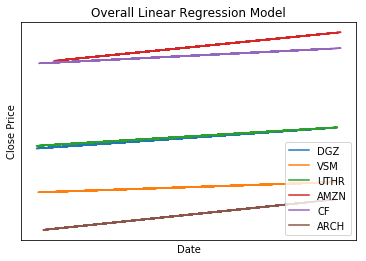

In [18]:
# Get similar five stocks from the stock list, using 'AMZN' as example
# Change it to any input stock symbol
symbol_test = 'AMZN'
top = get_similar_stock(coefficient_data, symbol_test)